# Creating NLP Word Embeddings with PyTorch

In [1]:
# https://stackoverflow.com/questions/50747947/embedding-in-pytorch
# https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

from IPython.display import clear_output
import time

In [3]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
#import mpld3
#mpld3.enable_notebook()
#!pip install --user "git+https://github.com/javadba/mpld3@display_fix"

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import nltk
from nltk.corpus import gutenberg
import re
from collections import Counter # collections library; counter: dict subclass for counting hashable objects

from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

In [8]:
from nlp_labs.utils2 import my_sentence_tokenizer, get_all_tokens, encode_sentence

## Load and Preprocess Corpus

In [9]:
tag_start = '<s>'
tag_end = '</s>'
tag_oov = '<unk>'
tag_pad = '<pad>'

tags = dict({'tag_start':tag_start, 'tag_end':tag_end,'tag_oov':tag_oov, 'tag_pad':tag_pad})

use_tags = True

In [10]:
'''corpus = gutenberg.words('shakespeare-caesar.txt') 
# 'bible-kjv.txt' 'melville-moby_dick.txt' 'shakespeare-hamlet.txt' 'shakespeare-caesar.txt',
print(type(corpus),len(corpus))
corpus_str = ' '.join(corpus)'''

with open("./data/shakespeare.txt", "rb") as f: # wiki_sample_corpusdataorg.txt shakespeare.txt
    txt = f.readlines()
corpus_str = ''.join([s.decode('utf-8') for s in txt])


print(type(corpus_str),len(corpus_str))
corpus_str = re.sub(r'[,!?;-]+', '.', corpus_str) # clean punctuation

doc = my_sentence_tokenizer(corpus_str,tag_start,tag_end,tag=use_tags,stopwords=stop_words)
tokens = get_all_tokens(doc)

n_print = 100
print(f'After cleaning:  {len(tokens)} tokens, first {n_print}  {tokens[:n_print]}')

# create vocab including word count using collections.Counter
word_count_vocab = dict()
word_count_vocab = Counter(tokens)

if tag_start in word_count_vocab:
    word_count_vocab.pop(tag_start)

if tag_end in word_count_vocab:
    word_count_vocab.pop(tag_end)

print(word_count_vocab.most_common(10))
print('count : ',len(word_count_vocab))


if use_tags:
    vocabulary = list(enumerate(sorted(set(word_count_vocab.keys())),start=4))
    for i, tag in enumerate(list(tags.values())):
        vocabulary.insert(i,(i,tag))
else:
    vocabulary = list(enumerate(sorted(set(word_count_vocab.keys())),start=0))

        
print(vocabulary[:10]) # sorted vocabulary

idx2word = dict(vocabulary)
list(idx2word.items())[0:10]

word2idx = dict({k:v for v, k in idx2word.items()})
list(word2idx.items())[:10]

coded_corpus = [word2idx[t] for t in tokens]

print(coded_corpus[202])
print(len(coded_corpus))

S = len(coded_corpus)           
V = len(word2idx)  

<class 'str'> 306996
After cleaning:  55296 tokens, first 100  ['<s>', 'muse', 'fire', '.', '</s>', '<s>', 'would', 'ascend', 'brightest', 'heaven', 'invention', '.', '</s>', '<s>', 'kingdom', 'stage', '.', '</s>', '<s>', 'princes', 'act', 'monarchs', 'behold', 'swelling', 'scene', '.', '</s>', '<s>', 'warlike', 'harry', '.', '</s>', '<s>', 'like', '.', '</s>', '<s>', 'assume', 'port', 'mars', '.', '</s>', '<s>', 'heels', '.', '</s>', '<s>', 'leash', 'like', 'hounds', '.', '</s>', '<s>', 'famine', '.', '</s>', '<s>', 'sword', 'fire', 'crouch', 'employment', '.', '</s>', '<s>', 'pardon', '.', '</s>', '<s>', 'gentles', '.', '</s>', '<s>', 'flat', 'unraised', 'spirits', 'dared', 'unworthy', 'scaffold', 'bring', 'forth', 'great', 'object', 'cockpit', 'hold', 'vasty', 'fields', 'france', '.', '</s>', '<s>', 'may', 'cram', 'within', 'wooden', 'casques', 'affright', 'air', 'agincourt', '.', '</s>']
[('.', 9597), ('thy', 359), ('thou', 332), ('love', 271), ('thee', 240), ('lord', 225), ('shall

In [11]:
S, V

(55296, 5656)

In [12]:
coded_corpus_np = np.array(coded_corpus)
coded_corpus_np.shape

(55296,)

In [13]:
def get_context(coded_sentence, context_size,word2idx, tags):
    
    # end_position = np.where(coded_sentence==word2idx[tags['tag_end']])[0].item()
    # apesar de quebrar a frase na hora certa, gera um problema de batches de tamanhos diferentes
    
    end_position = len(coded_sentence)
    
    target_context = []
    for pos in range(0,end_position):
        middle_word   = coded_sentence[pos]

        left_start = max(pos-context_size,0)
        right_end  = min(pos+1+context_size,end_position)

        if pos - left_start < context_size:                # first words position
            right_end += context_size-(pos-left_start)     # --> increse right_context size
        elif right_end-(pos+1) < context_size:             # last words position
            left_start -= context_size-(right_end-(pos+1)) # --> increase left_context size

        left_context  = coded_sentence[left_start:pos]
        right_context = coded_sentence[pos+1:right_end]
        
        
        context       = left_context + right_context # list concatenation

        target_context.append((middle_word,context))
    return target_context

In [14]:
def get_batches(coded_corpus, batch_size, half_context_size, S, V, word2idx, tags):
    i = 0
    while True:
        s = coded_corpus[i:i+batch_size]
        X = []
        Y = []
        for y, x in get_context(s, half_context_size, word2idx, tags):
            X.append(x)
            Y.append(y)
        
        yield (np.array(X), np.array(Y).reshape(-1,1))
        
        i += batch_size
        if i >= S-batch_size:
            print('i is being set to 0')
            i = 0

In [15]:
def get_train_vectors(context_batches, middle_word_batches):
    X_train = np.zeros(shape=(batch_size,V))
    #Y_train = np.zeros(shape=(batch_size,V))
    Y_train = np.zeros(shape=(batch_size))
    
    for context_id in range(context_batches.shape[0]):
        context     = context_batches[context_id]
        middle_word = middle_word_batches[context_id].item()
        for cw in  context:
            weight = 1 if word_count_vocab[idx2word[cw]] else 0
            X_train[context_id, cw] += weight/(2*half_context_size)
        
        # Y_train[context_id, middle_word] = 1
        Y_train[context_id] = middle_word
    return (torch.FloatTensor(X_train), torch.LongTensor(Y_train))
# X_train[np.where(X_train)]

In [16]:
batch_size = 10
half_context_size = 2
batch_generator = get_batches(coded_corpus=coded_corpus, 
                              batch_size=batch_size, half_context_size=half_context_size, 
                              S=S, V=V, word2idx=word2idx, tags=tags)

In [17]:
X, Y  = next(batch_generator)
X.shape, Y.shape, (batch_size)
#print(np.concatenate((X, Y),axis=1))

((10, 4), (10, 1), 10)

In [18]:
X_train, Y_train = get_train_vectors(context_batches=X, middle_word_batches=Y)
X_train.shape, Y_train.shape

(torch.Size([10, 5656]), torch.Size([10]))

In [19]:
i=3
np.where(X_train[i]), X_train[i,np.where(X_train[i])], Y_train[i]

((array([1907, 3207], dtype=int64),), tensor([[0.2500, 0.2500]]), tensor(4))

# Training the Embeddings with Language Model

## Continuous Bag-of-Words (CBOW)

context vs target

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints about PyTorch input layer format</b></font>
</summary>

[from here](https://discuss.pytorch.org/t/confused-about-tensor-dimensions-and-batches/4761/2)

    
> The input to a linear layer should be a tensor of size [batch_size, input_size] where input_size is the same size as the first layer in your network (so in your case it’s num_letters).  
    The problem appears in the line:  
    `tensor = torch.zeros(len(name), 1, num_letters)`  
    which should actually just be:  
    `tensor = torch.zeros(len(name), num_letters)`

> As an easy example:  
> ```python
        input_size = 8
        output_size = 14
        batch_size = 64
        net = nn.Linear(input_size, output_size)  
        input = Variable(torch.FloatTensor(batch_size, input_size))  
        output = net(input)  
        print("Output size:", output.size())
    
> ```CPP
    Output size: (64, 14)
    

> Hope this helps,  
  Jordan
</p>



In [20]:
class Language_Model_w2v(nn.Module):
    
    def __init__(self, vocab_size, num_of_dimensions_of_embedding):
        super(Language_Model_w2v, self).__init__()
        self.V  = vocab_size
        self.N  = num_of_dimensions_of_embedding 
        
        self.W1  = nn.Linear(self.V, self.N)
        self.H1  = nn.ReLU(inplace=True)
        
        self.W2 = nn.Linear(self.N, self.V)
        self.LogSoftMax = nn.LogSoftmax(dim=1)
        
        # self.layers = nn.Sequential(*[self.e, self.W1, self.W2,self.LogSoftMax])
        
    def forward(self,x):              
        x = self.H1(self.W1(x))
        x = self.LogSoftMax(self.W2(x))
        
        return x

In [21]:
max_epochs = 1
batch_size = 128
max_batch_iters = np.floor(S/batch_size)

Nd = 200
half_context_size = 2

lr = 1e-2

batch_generator = get_batches(coded_corpus=coded_corpus, 
                              batch_size=batch_size, half_context_size=half_context_size, 
                              S=S, V=V, word2idx=word2idx, tags=tags)
print_iters = 10

losses    = []
criterion = nn.NLLLoss()
model     = Language_Model_w2v(vocab_size=V, num_of_dimensions_of_embedding=Nd)

optimizer = optim.Adam(model.parameters(), lr=lr) 
#optimizer = optim.SGD(model.parameters(),lr=lr) 

In [22]:
model

Language_Model_w2v(
  (W1): Linear(in_features=5656, out_features=200, bias=True)
  (H1): ReLU(inplace=True)
  (W2): Linear(in_features=200, out_features=5656, bias=True)
  (LogSoftMax): LogSoftmax()
)

In [23]:
max_batch_iters

432.0

In [24]:
from time import time

batch_losses = []
for epoch in range(max_epochs):
    
    cnt = 0
    
    # coded_sentences = coded_sentences[:,np.random.permutation(S)]
    
    start_t = time()
    
    for X, Y in batch_generator:
    
        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words into integer indices and wrap them in tensors)
        X_train, Y_train = get_train_vectors(context_batches=X, middle_word_batches = Y)
        
        # Step 2. Recall that torch *accumulates* gradients. 
        # Before passing in a new instance, you need to zero out the gradients from the oldinstance
        model.zero_grad()
            
        # Step 3. Run the forward pass, getting log probabilities over next words
        log_probs = model(X_train)  
            
        # Step 4. Compute your loss function. 
        # (Again, Torch wants the target word wrapped in a tensor)
        loss = criterion(log_probs, Y_train.T)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        # total_loss += loss.item()
        
        batch_losses.append(loss)
        
        
        if cnt%print_iters==1:
            now = time()
            duration = 1000*(now - start_t)/cnt/batch_size
            print(f'epoch {epoch} sentence {cnt*batch_size}/{S} loss: {loss.item():.5f} ({duration:.5f} ms per word)')
            
            
        cnt+=1
            
        if cnt>=max_batch_iters:
            break
    
    #time.sleep(1.5)
    #clear_output()
#print(losses)  # The loss decreased every iteration over the training data!

epoch 0 sentence 128/55296 loss: 8.61760 (2.57904 ms per word)
epoch 0 sentence 1408/55296 loss: 7.44683 (1.39368 ms per word)
epoch 0 sentence 2688/55296 loss: 5.78196 (1.23501 ms per word)
epoch 0 sentence 3968/55296 loss: 6.70826 (1.21391 ms per word)
epoch 0 sentence 5248/55296 loss: 6.31944 (1.19710 ms per word)
epoch 0 sentence 6528/55296 loss: 5.81827 (1.18757 ms per word)
epoch 0 sentence 7808/55296 loss: 5.77460 (1.19465 ms per word)
epoch 0 sentence 9088/55296 loss: 6.11734 (1.18749 ms per word)
epoch 0 sentence 10368/55296 loss: 5.42291 (1.18687 ms per word)
epoch 0 sentence 11648/55296 loss: 5.11624 (1.18732 ms per word)
epoch 0 sentence 12928/55296 loss: 5.63395 (1.17403 ms per word)
epoch 0 sentence 14208/55296 loss: 5.31103 (1.16120 ms per word)
epoch 0 sentence 15488/55296 loss: 5.68863 (1.15690 ms per word)
epoch 0 sentence 16768/55296 loss: 4.70763 (1.15614 ms per word)
epoch 0 sentence 18048/55296 loss: 5.83393 (1.16278 ms per word)
epoch 0 sentence 19328/55296 loss:

## Plot Training Loss

In [25]:
batch_losses_np = np.array([loss.detach() for loss in batch_losses])

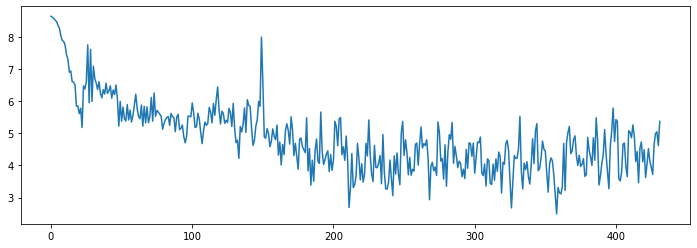

In [26]:
plt.figure(figsize=(12,4))

plt.plot(batch_losses_np)
plt.show();

## Extract Embedding

In [27]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape) # param.data

W1.weight torch.Size([200, 5656])
W1.bias torch.Size([200])
W2.weight torch.Size([5656, 200])
W2.bias torch.Size([5656])


In [28]:
# model.W2.bias.data.view(-1,1)
# model.W1.bias.data.T
# model.W2.weight.data
# model.W1.weight.data.T
#Embedding = model.W2.weight.data
Embedding = .5*(model.W1.weight.data.T + model.W2.weight.data)


Embedding.shape, Embedding

(torch.Size([5656, 200]),
 tensor([[ 1.6675e-02,  1.9098e-02,  3.4785e-03,  ...,  3.8808e-03,
           1.2059e-01,  7.3914e-01],
         [ 3.8224e-02, -2.5240e-02,  6.6362e-03,  ..., -8.2214e-03,
           3.7616e-01,  4.9187e-01],
         [-3.5991e-02, -6.0674e-04,  6.4544e-03,  ..., -6.2446e-02,
          -4.6587e-01, -6.1681e-01],
         ...,
         [-3.8194e-02, -3.3554e-02, -5.1734e-03,  ..., -1.8119e-02,
          -1.0975e-01, -1.1687e-01],
         [-5.2359e-02, -1.1665e-04, -2.1740e-02,  ..., -1.5391e-03,
          -1.7865e-01, -2.4632e-01],
         [-2.6841e-02,  1.7070e-02,  3.1027e-06,  ..., -2.6845e-02,
          -3.2920e-01, -4.1289e-01]]))

## Word Analogies

In [29]:
def word_analogy(pos_neg_1=('king','man'),pos_neg_2=('queen','woman'), n_closest = 4, word2idx=None, idx2word=None):
    king_w,    man_w = pos_neg_1
    queen_w, woman_w = pos_neg_2
    
    for w in (king_w,man_w,woman_w):
        if w not in word2idx:
            # raise Exception(f'sorry, word "{w}" not in dictionary.')
            print(f'sorry, word "{w}" not in dictionary.')
            return None
        
    print(f'Expected: {king_w} - {man_w} = {queen_w} - {woman_w}')
    
    king   = word2idx[king_w]
    man    = word2idx[man_w]
    woman  = word2idx[woman_w]
    
    vec = (Embedding[king] - Embedding[man] + Embedding[woman]).view(1,-1) # Embedding[queen]
    
    
    distances = pairwise_distances(vec.reshape(1, -1), Embedding, metric='cosine').reshape(V)
    idx = distances.argsort()[:n_closest+3] 
    idx = [x for x in idx if x not in set([man,king,woman])]
    queen_estimated = idx2word[idx[0]]
    
    print(f'Got:      {king_w} - {man_w} = {queen_estimated} - {woman_w}')
    
    print(f'Closest {len(idx[:n_closest])} words:')
    for i in idx[:n_closest]:
        print(f'{idx2word[i]}')

In [30]:
analogy_list = [('father', 'man', 'mother', 'woman'),
               ('prince','king','princess','queen'),
               ('me','i','his','he'),
               ('brother','man','sister','woman'),
               ('boy','man','girl','woman'),
               ('man','woman','husband','wife'),
               ('man','woman','he','she'),
               ('king','man','queen','woman')]

for w1, w2, w3, w4 in analogy_list:
    word_analogy(pos_neg_1=(w1,w2),pos_neg_2=(w3,w4), n_closest = 10, word2idx=word2idx, idx2word=idx2word)
    print()

Expected: father - man = mother - woman
Got:      father - man = herd - woman
Closest 10 words:
herd
breach
derive
hazard
curls
breed
actor
rule
lower
darling

Expected: prince - king = princess - queen
Got:      prince - king = several - queen
Closest 10 words:
several
third
proper
heavenly
freer
chid
powers
wenches
teeth
hearts

sorry, word "me" not in dictionary.

Expected: brother - man = sister - woman
Got:      brother - man = trees - woman
Closest 10 words:
trees
makeless
youngly
wilder
unprovident
expedition
strike
impanelled
english
chaces

Expected: boy - man = girl - woman
Got:      boy - man = fed - woman
Closest 10 words:
fed
politic
except
physicians
stretch
afar
gentlewoman
wondrous
pursuit
owing

Expected: man - woman = husband - wife
Got:      man - woman = noble - wife
Closest 10 words:
noble
go
widow
messenger
king
diana
come
lady
fortune
good

sorry, word "she" not in dictionary.

Expected: king - man = queen - woman
Got:      king - man = lafeu - woman
Closest 10 w

## Closest Neighbors

In [31]:
def get_closest_from(word,n_closest=5, word2idx=None, idx2word=None):
    
    if word not in word2idx:
        # raise Exception(f'sorry, word "{w}" not in dictionary.')
        print(f'sorry, word "{word}" not in dictionary.')
        return None
    
    word_idx = word2idx[word]
    vec = Embedding[word_idx]
    
    distances = pairwise_distances(vec.reshape(1, -1), Embedding, metric='cosine').reshape(V)
    idx = distances.argsort()[:n_closest+1] 
    idx = [x for x in idx if x not in set([word_idx])]
    
    print(f'Closest {len(idx)} words from {word}:')
    for i in idx[:n_closest]:
        print(f'{idx2word[i]}') 

In [32]:
word_list = ['man', 'king', 'woman', 'queen', 'god', 'brother', 'sister', 'death', 'life', 'dog']

for word in word_list:
    get_closest_from(word,n_closest=6, word2idx=word2idx, idx2word=idx2word)
    print()

Closest 6 words from man:
wife
lady
fortune
go
noble
widow

Closest 6 words from king:
lafeu
ay
</s>
countess
bertram
clown

Closest 6 words from woman:
perceive
nights
gold
strike
justice
hideous

Closest 6 words from queen:
gracious
condemn
lepidus
egypt
lov
iras

Closest 6 words from god:
please
bidding
certainty
liking
sent
melancholy

Closest 6 words from brother:
messengers
perceive
meaning
freedom
paper
deny

Closest 6 words from sister:
ca
iris
parson
forsooth
honoured
knee

Closest 6 words from death:
remedy
got
rest
adieu
measure
peace

Closest 6 words from life:
worth
strange
haply
grace
wonder
intelligence

Closest 6 words from dog:
defend
rightful
print
omit
vengeance
predecessor



# PCA Visualization of Word-Analogy

In [33]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=2)
pca.fit(Embedding)
Embedding_2D = pca.transform(Embedding)

In [35]:
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label

In [36]:
p = figure()

# output to static HTML file
output_file("embeeded_word_vectors_pca.html")

Nplot = 1000

most_common_words = [word2idx[x[0]] for x in word_count_vocab.most_common(Nplot)]

p.scatter(x=Embedding_2D[most_common_words,0], y=Embedding_2D[most_common_words,1])

for i in most_common_words:
    my_text = Label(text=idx2word[i], x=Embedding_2D[i,0],y=Embedding_2D[i,1])
    p.add_layout(my_text)
    
show(p)

In [37]:
words = ['king', 'queen',
         'lord', 'lady',
         'man', 'woman',
         'dog','wolf',
         'rich','poor',
         'happy','sad']


p = figure()

# output to static HTML file
output_file("embeeded_word_vectors_pca_wordlist.html")

most_common_words = [word2idx[x] for x in words if x in word2idx]

p.scatter(x=Embedding_2D[most_common_words,0], y=Embedding_2D[most_common_words,1])

for i in most_common_words:
    my_text = Label(text=idx2word[i], x=Embedding_2D[i,0],y=Embedding_2D[i,1])
    p.add_layout(my_text)
    
show(p)